In [1]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip  -O /tmp/horse-or-human.zip

--2021-01-04 11:14:22--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  95.6MB/s    in 1.5s    

2021-01-04 11:14:24 (95.6 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [2]:
import os
import zipfile
 
local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

In [3]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')
 
# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

In [4]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])
train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse13-3.png', 'horse18-1.png', 'horse39-5.png', 'horse40-0.png', 'horse01-6.png', 'horse29-6.png', 'horse21-9.png', 'horse20-4.png', 'horse26-2.png', 'horse32-6.png']
['human05-08.png', 'human07-19.png', 'human10-03.png', 'human16-28.png', 'human12-11.png', 'human07-09.png', 'human16-04.png', 'human14-13.png', 'human09-05.png', 'human17-22.png']


In [5]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


In [6]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
 
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
 
# Index for iterating over images
pic_index = 0

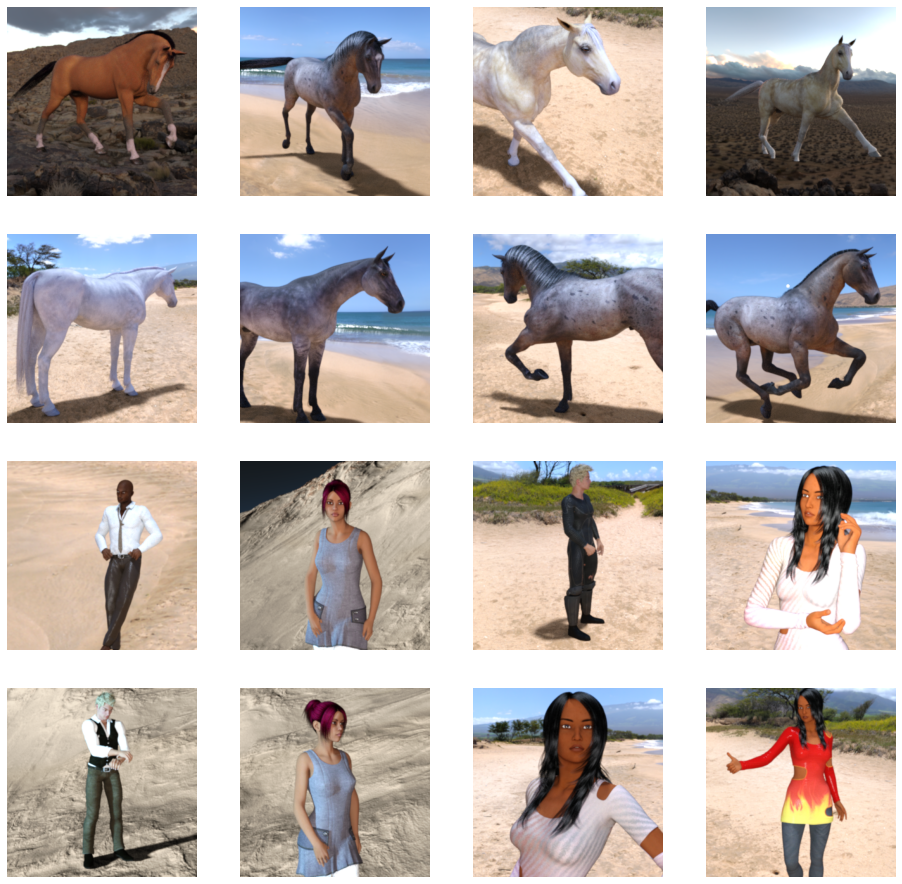

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
 
pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]
 
for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
 
  img = mpimg.imread(img_path)
  plt.imshow(img)
 
plt.show()

Define the Model

In [9]:
import tensorflow as tf

In [10]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [12]:
from tensorflow.keras.optimizers import RMSprop
 
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
 
# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.


In [14]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1)

Epoch 1/15
8/8 [==============================] - 79s 9s/step - loss: 3.1607 - acc: 0.5521
Epoch 2/15
8/8 [==============================] - 72s 10s/step - loss: 0.6668 - acc: 0.5256
Epoch 3/15
8/8 [==============================] - 72s 9s/step - loss: 0.5911 - acc: 0.7999
Epoch 4/15
8/8 [==============================] - 73s 9s/step - loss: 0.5612 - acc: 0.8003
Epoch 5/15
8/8 [==============================] - 72s 9s/step - loss: 0.2801 - acc: 0.8695
Epoch 6/15
8/8 [==============================] - 72s 9s/step - loss: 0.4085 - acc: 0.8378
Epoch 7/15
8/8 [==============================] - 72s 9s/step - loss: 0.8275 - acc: 0.8169
Epoch 8/15
8/8 [==============================] - 82s 10s/step - loss: 0.1809 - acc: 0.9433
Epoch 9/15
8/8 [==============================] - 76s 11s/step - loss: 0.1051 - acc: 0.9575
Epoch 10/15
8/8 [==============================] - 72s 10s/step - loss: 1.4127 - acc: 0.7508
Epoch 11/15
8/8 [==============================] - 72s 9s/step - loss: 0.2007 - acc: 

In [15]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")

Saving cat.jpg to cat.jpg
[1.]
cat.jpg is a human


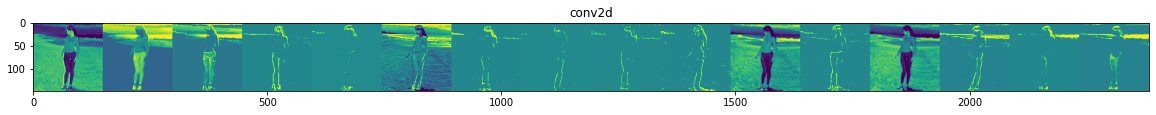

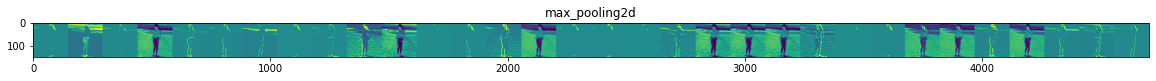

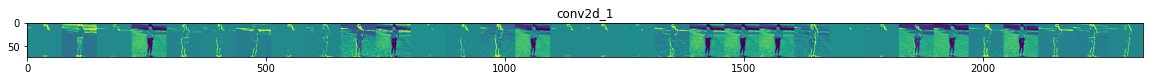

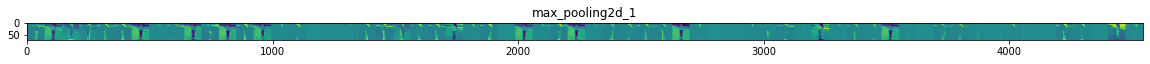

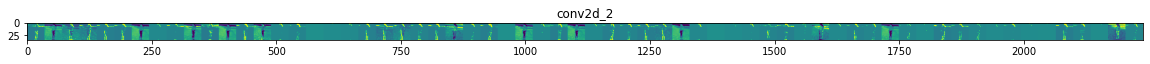

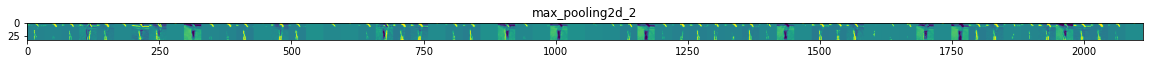

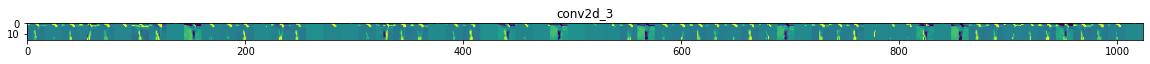

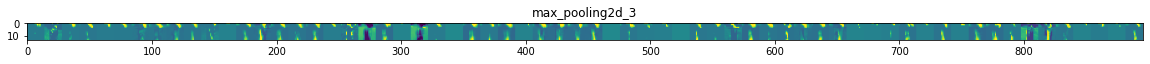

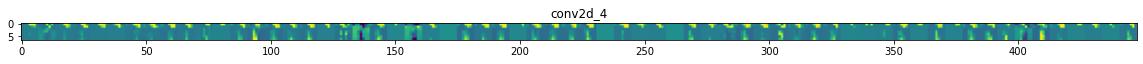

In [16]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
 
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)
 
img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)
 
# Rescale by 1/255
x /= 255
 
# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)
 
# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
 
# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      if x.std()>0:
        x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')